# LSTMs for review classifications

## Loading Dataset

In [ ]:
# ! pip install tensorflow_datasets tensorflow

In [3]:
import tensorflow_datasets as tfds

imdb, info = tfds.load('imdb_reviews/subwords8k', as_supervised=True, with_info=True)
print(imdb, info)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>} tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='

## Data preprocessing

In [4]:
tokenizer = info.features['text'].encoder
print(dir(tokenizer))

print('Training size', info.splits['train'].num_examples)
print('Testing size', info.splits['test'].num_examples)

BUFF_SIZE = info.splits['train'].num_examples
BATCH_SIZE = 256

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_from_token_counts', '_byte_encode', '_cache_size', '_filename', '_id_to_subword', '_init_from_list', '_max_subword_len', '_read_lines_from_file', '_subword_to_id', '_subwords', '_token_to_ids', '_token_to_ids_cache', '_token_to_subwords', '_tokenizer', '_write_lines_to_file', 'build_from_corpus', 'decode', 'encode', 'load_from_file', 'save_to_file', 'subwords', 'vocab_size']
Training size 25000
Testing size 25000


In [5]:
training_dataset, testing_dataset = imdb['train'], imdb['test']

training_dataset = training_dataset.shuffle(BUFF_SIZE)
training_dataset = training_dataset.padded_batch(BATCH_SIZE)
testing_dataset = testing_dataset.padded_batch(BATCH_SIZE)

## Single Layer LSTM Model

### Hyperparameters

In [6]:
VOCAB_SIZE = tokenizer.vocab_size
EPOCHS = 8
EMBEDDING_DIM = 32
LSTM_UNITS = 64
DENSE_NEURONS = 8

In [10]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS)),
    tf.keras.layers.Dense(DENSE_NEURONS, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          261920    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 312625 (1.19 MB)
Trainable params: 312625 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [ ]:
hist_data = model.fit(training_dataset, validation_data=testing_dataset, epochs=EPOCHS)

Epoch 1/8
98/98 [==============================] - 44s 370ms/step - loss: 0.6322 - accuracy: 0.6473 - val_loss: 0.5223 - val_accuracy: 0.7727
Epoch 2/8
98/98 [==============================] - 36s 360ms/step - loss: 0.4284 - accuracy: 0.8203 - val_loss: 0.3987 - val_accuracy: 0.8374
Epoch 3/8
98/98 [==============================] - 26s 248ms/step - loss: 0.3068 - accuracy: 0.8830 - val_loss: 0.4086 - val_accuracy: 0.8248
Epoch 4/8
98/98 [==============================] - 24s 243ms/step - loss: 0.2450 - accuracy: 0.9082 - val_loss: 0.3576 - val_accuracy: 0.8497
Epoch 5/8
98/98 [==============================] - 23s 232ms/step - loss: 0.2582 - accuracy: 0.9006 - val_loss: 0.4292 - val_accuracy: 0.8078
Epoch 6/8
98/98 [==============================] - 21s 210ms/step - loss: 0.2101 - accuracy: 0.9225 - val_loss: 0.4161 - val_accuracy: 0.8510
Epoch 7/8
98/98 [==============================] - 21s 211ms/step - loss: 0.1649 - accuracy: 0.9425 - val_loss: 0.4071 - val_accuracy: 0.8482
Epoch 

## Plotting Metrics

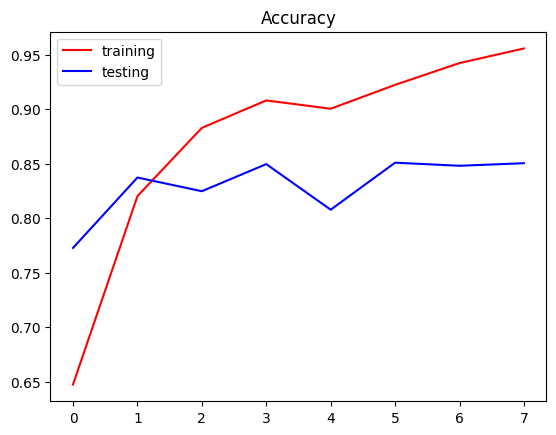

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist_data.history['accuracy'], 'r', label='training')
plt.plot(hist_data.history['val_accuracy'], 'b', label='testing')
plt.title('Accuracy')
plt.legend()
plt.show()

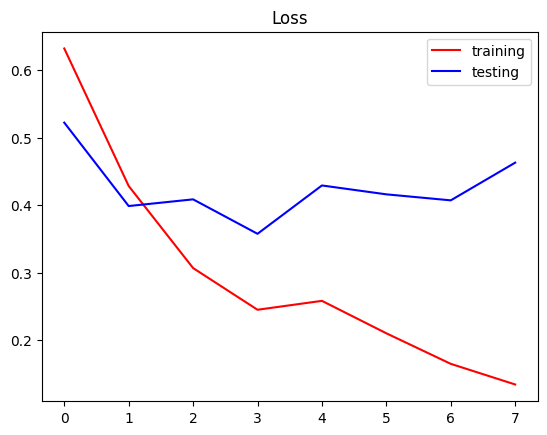

In [ ]:
plt.plot(hist_data.history['loss'], 'r', label='training')
plt.plot(hist_data.history['val_loss'], 'b', label='testing')
plt.title('Loss')
plt.legend()
plt.show()

## Random Prediction

In [ ]:
random_sentence = b'This movie is Best shit'
random_sequence = tokenizer.encode(random_sentence)
outputs = model.predict([random_sequence])
print(outputs)

if outputs[0] > 0.5:
    print(info.features['label'].names[1],'review')
else:
    print(info.features['label'].names[0],'review')

1/1 [==============================] - 1s 727ms/step
[[0.7955675]]
pos review


## Saving embeddings

In [ ]:
# Get the index-word dictionary
# reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)


(8185, 32)


In [ ]:
! mkdir ./week3

In [ ]:
import io

# Open writeable files
out_v = io.open('./week3/vecs_subwords1.tsv', 'w', encoding='utf-8')
out_m = io.open('./week3/meta_subwords1.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, VOCAB_SIZE):

  # Get the word associated at the current index
  word_name = tokenizer._id_to_subword(word_num-1)

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(str(word_name) + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

## Multilayer LSTM model

In [11]:
LSTM2_UNITS = 32

In [12]:
import tensorflow as tf

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_UNITS)),
    tf.keras.layers.Dense(DENSE_NEURONS, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [14]:
hist_data2 = model2.fit(training_dataset, validation_data=testing_dataset, epochs=EPOCHS)

Epoch 1/8


KeyboardInterrupt: 

## Plotting Metrics

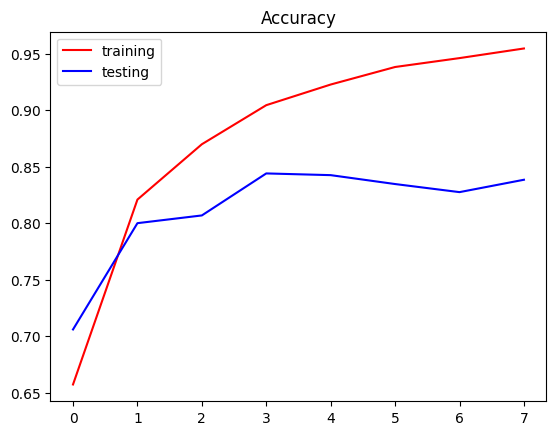

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist_data2.history['accuracy'], 'r', label='training')
plt.plot(hist_data2.history['val_accuracy'], 'b', label='testing')
plt.title('Accuracy')
plt.legend()
plt.show()

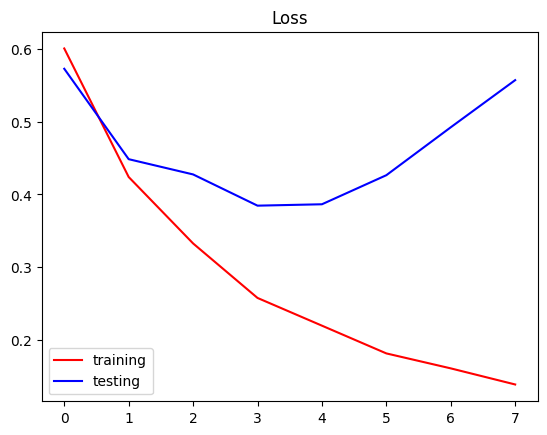

In [ ]:
plt.plot(hist_data2.history['loss'], 'r', label='training')
plt.plot(hist_data2.history['val_loss'], 'b', label='testing')
plt.title('Loss')
plt.legend()
plt.show()

## Random Prediction

In [ ]:
random_sentence = b'This movie is Best shit'
random_sequence = tokenizer.encode(random_sentence)
outputs = model2.predict([random_sequence])
print(outputs)

if outputs[0] > 0.5:
    print(info.features['label'].names[1],'review')
else:
    print(info.features['label'].names[0],'review')

1/1 [==============================] - 2s 2s/step
[[0.72037566]]
pos review


## Saving embeddings

In [ ]:
# Get the index-word dictionary
# reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model2.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)


(8185, 32)


In [ ]:
! mkdir ./week3

mkdir: cannot create directory ‘./week3’: File exists


In [ ]:
import io

# Open writeable files
out_v = io.open('./week3/vecs_subwords2.tsv', 'w', encoding='utf-8')
out_m = io.open('./week3/meta_subwords2.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, VOCAB_SIZE):

  # Get the word associated at the current index
  word_name = tokenizer._id_to_subword(word_num-1)

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(str(word_name) + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

## CNN layer Model

Hyperparameters

In [7]:
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 32
NUM_FILTERS = 16
FILTER_SIZE = (3,)

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Embedding, GlobalAveragePooling1D

model3 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          261920    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1552      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263617 (1.01 MB)
Trainable params: 263617 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [9]:
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [10]:
hist_data3 = model3.fit(training_dataset, validation_data=testing_dataset, epochs=16)

Epoch 1/16
98/98 [==============================] - 6s 59ms/step - loss: 0.6924 - accuracy: 0.5120 - val_loss: 0.6885 - val_accuracy: 0.5819
Epoch 2/16
98/98 [==============================] - 5s 55ms/step - loss: 0.6637 - accuracy: 0.6365 - val_loss: 0.6238 - val_accuracy: 0.7773
Epoch 3/16
98/98 [==============================] - 6s 62ms/step - loss: 0.5340 - accuracy: 0.8002 - val_loss: 0.4595 - val_accuracy: 0.8272
Epoch 4/16
98/98 [==============================] - 6s 62ms/step - loss: 0.3725 - accuracy: 0.8801 - val_loss: 0.3661 - val_accuracy: 0.8675
Epoch 5/16
98/98 [==============================] - 6s 57ms/step - loss: 0.2898 - accuracy: 0.9045 - val_loss: 0.3308 - val_accuracy: 0.8761
Epoch 6/16
98/98 [==============================] - 5s 53ms/step - loss: 0.2492 - accuracy: 0.9167 - val_loss: 0.3151 - val_accuracy: 0.8791
Epoch 7/16
98/98 [==============================] - 5s 54ms/step - loss: 0.2213 - accuracy: 0.9251 - val_loss: 0.3225 - val_accuracy: 0.8726
Epoch 8/16
98

## Plotting data

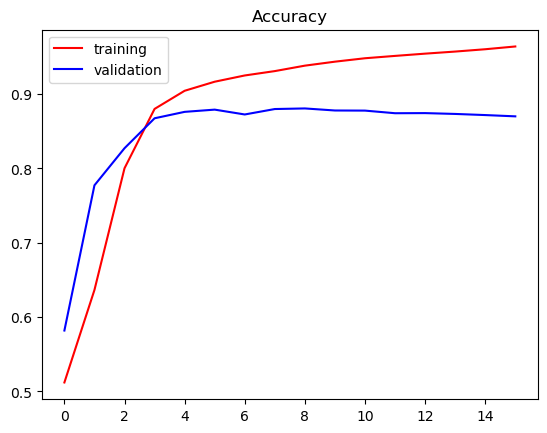

In [11]:
import matplotlib.pyplot as plt

plt.plot(hist_data3.history['accuracy'], 'r', label='training')
plt.plot(hist_data3.history['val_accuracy'], 'b', label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()

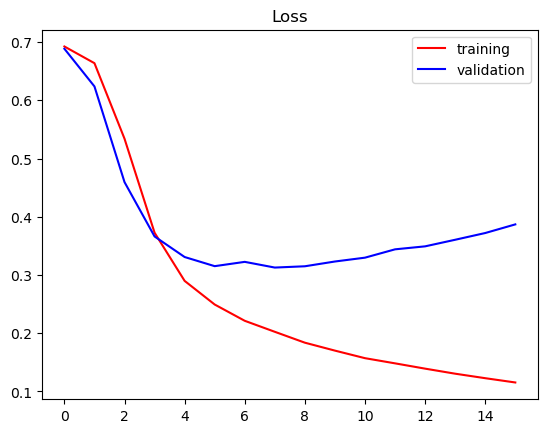

In [12]:
plt.plot(hist_data3.history['loss'], 'r', label='training')
plt.plot(hist_data3.history['val_loss'], 'b', label='validation')
plt.title('Loss')
plt.legend()
plt.show()

Observations: CNN based model performs best out of all when trained on less no.of epochs. 

## Understanding dimensions of CNN and LSTM layers

CNN layer

In [23]:
import numpy as np

'''
Single input array shape is: (batchsize, timesteps, no. of features)
timesteps = Single Sequence Length
no. of features = embedding dimensions of each word vector = embedding_dim
'''
BATCH_SIZE = 1
TIMESTEPS = 20
NUM_FEATURES = 16

random_input = np.random.randn(BATCH_SIZE, TIMESTEPS, NUM_FEATURES)
cnn_layer = Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu')
result = cnn_layer(random_input)

print(result)
print(result.shape)
# dir(cnn_layer)


tf.Tensor(
[[[0.28642628 0.32267228 1.2288749  0.         0.7716793  0.12107529
   1.1841463  0.         0.1804829  1.0652077  0.8055854  0.
   0.         1.6664778  0.85709864 0.        ]
  [0.         0.6579674  0.27599558 0.         0.         0.4048247
   0.0335793  0.6860009  0.         0.44683272 0.31475493 0.9944911
   0.63880396 0.         0.26064256 0.        ]
  [0.         0.         1.2018942  0.         0.58568263 0.5064397
   1.0909108  0.         0.3054494  1.4897078  0.82647955 0.7990318
   0.         0.3019913  0.74824715 0.        ]
  [0.         0.8733697  0.09746312 0.         0.63500136 0.
   1.1512556  0.         0.3970697  0.         0.         0.
   0.5052866  0.         1.2966173  0.0774211 ]
  [0.         0.         0.         0.8036426  1.3519636  0.
   1.8965473  0.         0.6120701  0.87366205 0.         0.35406575
   0.         0.26478553 0.         0.9349004 ]
  [0.29491132 0.         0.4340327  1.5948286  0.         0.48242185
   0.         0.         1

In [26]:
gap_result = GlobalAveragePooling1D()(result)
print(gap_result)
print(gap_result.shape)

'''
GAP layer sums up embeddings of all words in the sequence
and gives a single vector of embedding dimension
'''

tf.Tensor(
[[0.26080415 0.43226582 0.57709765 0.33834612 0.53171754 0.6390439
  0.520375   0.3108556  0.3394848  0.36314285 0.5474153  0.34409136
  0.36356366 0.4238439  0.51680386 0.43454507]], shape=(1, 16), dtype=float32)
(1, 16)


'\nGAP layer sums up embeddings of all words in the sequence\nand gives a single vector of embedding dimension\n'

LSTM layer

In [30]:
from tensorflow.keras.layers import LSTM

LSTM_UNITS = 10

lstm_result = LSTM(LSTM_UNITS)
# No returning sequences
result = lstm_result(random_input)
print(random_input.shape)
print(result.shape)

# With returning sequences here
lstm_result2 = LSTM(LSTM_UNITS, return_sequences=True)
result2 = lstm_result2(random_input)
print(result2.shape)


(1, 20, 16)
(1, 10)
(1, 20, 10)


### Saving CNN embeddings

In [32]:
# Get the index-word dictionary
# reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model3.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)


(8185, 32)


In [33]:
! mkdir ./week3

In [34]:
import io

# Open writeable files
out_v = io.open('./week3/vecs_subwords3.tsv', 'w', encoding='utf-8')
out_m = io.open('./week3/meta_subwords3.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, VOCAB_SIZE):

  # Get the word associated at the current index
  word_name = tokenizer._id_to_subword(word_num-1)

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(str(word_name) + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()